# How to create map-reduce branches for parallel execution

[Map-reduce](https://en.wikipedia.org/wiki/MapReduce) operations are essential for efficient task decomposition and parallel processing. This approach involves breaking a task into smaller sub-tasks, processing each sub-task in parallel, and aggregating the results across all of the completed sub-tasks. 

Consider this example: given a general topic from the user, generate a list of related subjects, generate a joke for each subject, and select the best joke from the resulting list. In this design pattern, a first node may generate a list of objects (e.g., related subjects) and we want to apply some other node (e.g., generate a joke) to all those objects (e.g., subjects). However, two main challenges arise.
 
(1) the number of objects (e.g., subjects) may be unknown ahead of time (meaning the number of edges may not be known) when we lay out the graph and (2) the input State to the downstream Node should be different (one for each generated object).
  
LangGraph addresses these challenges [through its `Send` API](/langgraphjs/concepts/low_level/#send). By utilizing conditional edges, `Send` can distribute different states (e.g., subjects) to multiple instances of a node (e.g., joke generation). Importantly, the sent state can differ from the core graph's state, allowing for flexible and dynamic workflow management. 

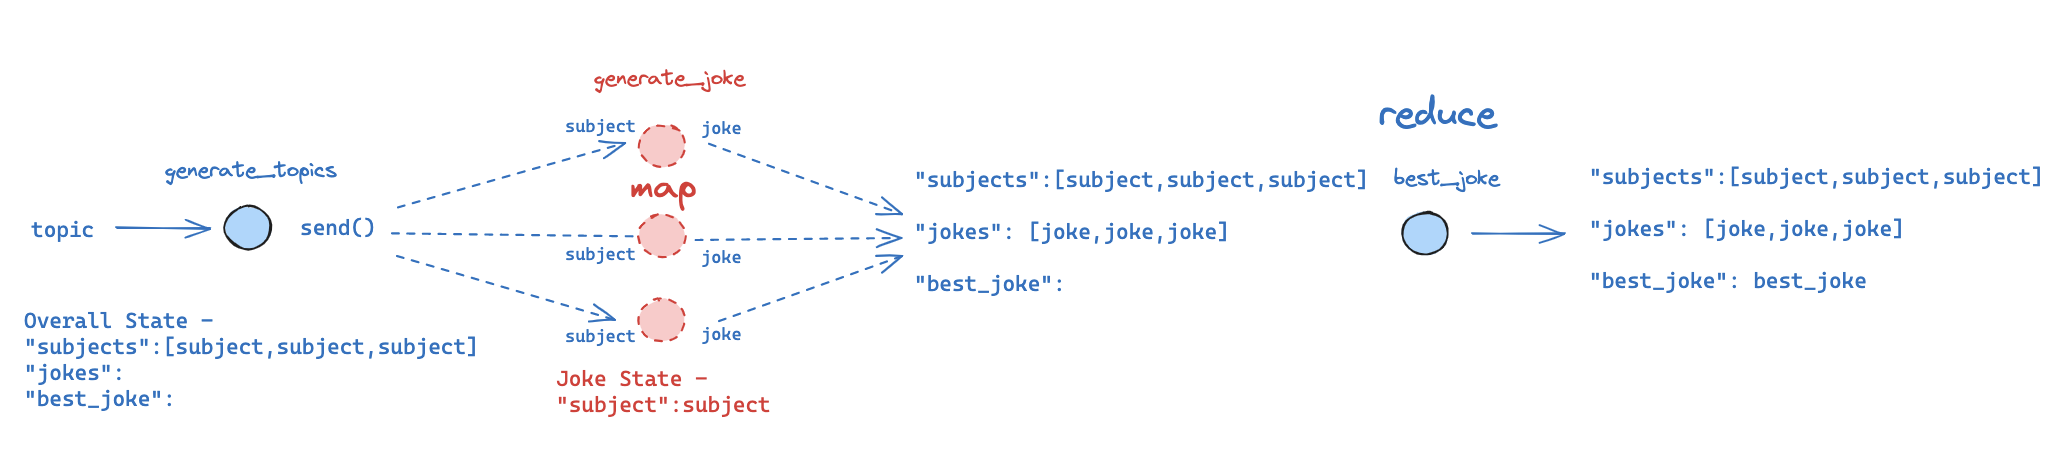

## Setup

This example will require a few dependencies. First, install the LangGraph library, along with the `@langchain/anthropic` package as we'll be using Anthropic LLMs in this example:

```bash
npm install @langchain/langgraph @langchain/anthropic @langchain/core
```

Next, set your Anthropic API key:

```typescript
process.env.ANTHROPIC_API_KEY = 'YOUR_API_KEY'
```

In [1]:
import { z } from "zod";
import { ChatAnthropic } from "@langchain/anthropic";
import { StateGraph, END, START, Annotation, Send } from "@langchain/langgraph";

/* Model and prompts */

// Define model and prompts we will use
const subjectsPrompt = "Generate a comma separated list of between 2 and 5 examples related to: {topic}."
const jokePrompt = "Generate a joke about {subject}"
const bestJokePrompt = `Below are a bunch of jokes about {topic}. Select the best one! Return the ID (index) of the best one.

{jokes}`

// Zod schemas for getting structured output from the LLM
const Subjects = z.object({
  subjects: z.array(z.string()),
});
const Joke = z.object({
  joke: z.string(),
});
const BestJoke = z.object({
  id: z.number(),
});

const model = new ChatAnthropic({
  model: "claude-3-5-sonnet-20240620",
});

/* Graph components: define the components that will make up the graph */

// This will be the overall state of the main graph.
// It will contain a topic (which we expect the user to provide)
// and then will generate a list of subjects, and then a joke for
// each subject
const OverallState = Annotation.Root({
  topic: Annotation<string>,
  subjects: Annotation<string[]>,
  // Notice here we pass a reducer function.
  // This is because we want combine all the jokes we generate
  // from individual nodes back into one list.
  jokes: Annotation<string[]>({
    reducer: (state, update) => state.concat(update),
  }),
  bestSelectedJoke: Annotation<string>,
});

// This will be the state of the node that we will "map" all
// subjects to in order to generate a joke
interface JokeState {
  subject: string;
}

// This is the function we will use to generate the subjects of the jokes
const generateTopics = async (
  state: typeof OverallState.State
): Promise<Partial<typeof OverallState.State>> => {
  const prompt = subjectsPrompt.replace("topic", state.topic);
  const response = await model
    .withStructuredOutput(Subjects, { name: "subjects" })
    .invoke(prompt);
  return { subjects: response.subjects };
};

// Function to generate a joke
const generateJoke = async (state: JokeState): Promise<{ jokes: string[] }> => {
  const prompt = jokePrompt.replace("subject", state.subject);
  const response = await model
    .withStructuredOutput(Joke, { name: "joke" })
    .invoke(prompt);
  return { jokes: [response.joke] };
};

// Here we define the logic to map out over the generated subjects
// We will use this an edge in the graph
const continueToJokes = (state: typeof OverallState.State) => {
  // We will return a list of `Send` objects
  // Each `Send` object consists of the name of a node in the graph
  // as well as the state to send to that node
  return state.subjects.map((subject) => new Send("generateJoke", { subject }));
};

// Here we will judge the best joke
const bestJoke = async (
  state: typeof OverallState.State
): Promise<Partial<typeof OverallState.State>> => {
  const jokes = state.jokes.join("\n\n");
  const prompt = bestJokePrompt
    .replace("jokes", jokes)
    .replace("topic", state.topic);
  const response = await model
    .withStructuredOutput(BestJoke, { name: "best_joke" })
    .invoke(prompt);
  return { bestSelectedJoke: state.jokes[response.id] };
};

// Construct the graph: here we put everything together to construct our graph
const graph = new StateGraph(OverallState)
  .addNode("generateTopics", generateTopics)
  .addNode("generateJoke", generateJoke)
  .addNode("bestJoke", bestJoke)
  .addEdge(START, "generateTopics")
  .addConditionalEdges("generateTopics", continueToJokes)
  .addEdge("generateJoke", "bestJoke")
  .addEdge("bestJoke", END);

const app = graph.compile();

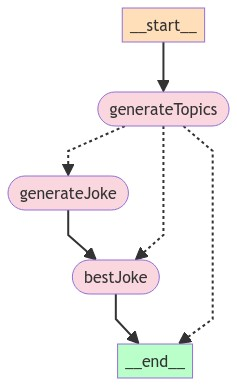

In [2]:
import * as tslab from "tslab";

const representation = app.getGraph();
const image = await representation.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

tslab.display.png(new Uint8Array(arrayBuffer));

In [3]:
// Call the graph: here we call it to generate a list of jokes
for await (const s of await app.stream({ topic: "animals" })) {
  console.log(s);
}

{
  generateTopics: { subjects: [ 'lion', 'elephant', 'penguin', 'dolphin' ] }
}
{
  generateJoke: {
    jokes: [ "Why don't lions like fast food? Because they can't catch it!" ]
  }
}
{
  generateJoke: {
    jokes: [
      "Why don't elephants use computers? Because they're afraid of the mouse!"
    ]
  }
}
{
  generateJoke: {
    jokes: [
      "Why don't dolphins use smartphones? They're afraid of phishing!"
    ]
  }
}
{
  generateJoke: {
    jokes: [
      "Why don't you see penguins in Britain? Because they're afraid of Wales!"
    ]
  }
}
{
  bestJoke: {
    bestSelectedJoke: "Why don't elephants use computers? Because they're afraid of the mouse!"
  }
}
